Preprocess the data: You will need to preprocess the Flavia dataset by resizing the images to a fixed size, converting them to grayscale, and splitting them into training, validation, and test sets.  

Build a CNN model: You will need to design and implement a CNN model architecture that can effectively classify plant leaves based on their images.   

Train the model: You will need to train the CNN model on the preprocessed Flavia dataset using appropriate hyperparameters and regularization techniques.  

Evaluate the model: You will need to evaluate the performance of the trained CNN model on the test set of the Flavia dataset using appropriate evaluation metrics such as accuracy, precision, recall, and F1 score.  

Analyze the results: You will need to analyze the performance of the model and identify any potential areas for improvement. You can visualize the learned features of the model, plot confusion matrices, and perform other analysis techniques to gain insights into the model's behavior.

In [156]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# global image params
batch_size = 32
img_height = 128
img_width = 128
data_dir = "Leaves/"

# get image paths
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*.jpg')))
print("image count", image_count)
img_paths = list(data_dir.glob('*.jpg'))
print(img_paths)
# create label directory
label_df = pd.read_csv('./Leaves/all.csv', index_col=0)
display(label_df.head())

In [140]:
label_df['path'] = label_df['id'].apply(lambda x: str(data_dir / x))
display(label_df.head())

# Convert to TensorFlow dataset
file_paths = label_df['path'].values
labels = label_df['y'].values
num_classes = len(np.unique(labels))
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

# Read, resize, greyscale images, normalize
def process_dataset(img_path , label):
    # Read the image from the file
    img = tf.io.read_file(img_path)
    # Decode the image into tensor format
    img = tf.image.decode_jpeg(img, channels=3)
    # resize images
    img = tf.image.resize(img, [img_height, img_width])
    # turn to greyscale 
    img = tf.image.rgb_to_grayscale(img)
    # normalize 
    # tf.image.convert_image_dtype(input_image, tf.float32) / 255
    img = img / 255
    
    return img, label

,id,y,path
0,1300.jpg,5,Leaves/1300.jpg
1,3152.jpg,23,Leaves/3152.jpg
2,1439.jpg,9,Leaves/1439.jpg
3,1243.jpg,4,Leaves/1243.jpg
4,1186.jpg,3,Leaves/1186.jpg


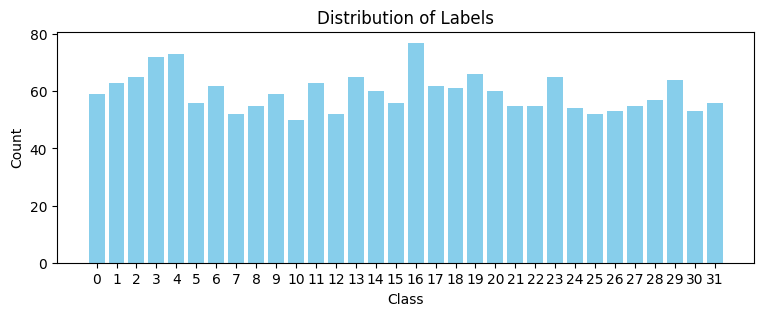

In [177]:
# Calculate label distribution
label_counts = label_df['y'].value_counts().sort_index()

# Plot distribution
plt.figure(figsize=(9, 3))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(ticks=label_counts.index)
plt.show()

In [141]:
dataset = dataset.map(process_dataset)

for img, label in dataset.take(1):
    print(f"Image shape: {img.shape}")
    print(f"Label shape: {label.shape}")

Image shape: (128, 128, 1)
Label shape: ()


In [118]:
# Shuffle and split the dataset into training and validation
dataset = dataset.shuffle(buffer_size=image_count, seed=123)
train_size = int(0.8 * image_count)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

print("Number of training samples:", train_size)
print("Number of validation samples:", image_count - train_size)

# Batch and prefetch the datasets
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Number of training samples: 1525
Number of validation samples: 382


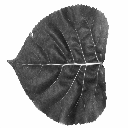

Label: 29 <class 'numpy.int64'>
Image shape: (32, 128, 128, 1)
Label shape: (32,)


In [146]:
# Display the image
for img_tensor, label in train_ds.take(1):
    img_array = img_tensor[0].numpy()
    img_array = (img_array * 255).astype('uint8')  # Convert back to uint8
    pil_img = Image.fromarray(img_array.squeeze())
    display(pil_img)
    print("Label:", label[0].numpy(), type(label[0].numpy()))
    print(f"Image shape: {img_tensor.shape}")
    print(f"Label shape: {label.shape}")
    break

In [148]:
def build_cnn_plant_classifier(num_classes):
    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Input((img_width,img_height,1)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = build_cnn_plant_classifier(num_classes)
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │     4,064,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,064,608 (15.51 MB)

 Trainable params: 4,064,608 (15.51 MB)

 Non-trainable params: 0 (0.00 B)

In [150]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.1103 - loss: 11.9335 - val_accuracy: 0.4764 - val_loss: 1.9806
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6294 - loss: 1.6065 - val_accuracy: 0.7749 - val_loss: 0.9459
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8215 - loss: 0.7737 - val_accuracy: 0.8010 - val_loss: 0.6991
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8840 - loss: 0.5101 - val_accuracy: 0.8429 - val_loss: 0.5367
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9230 - loss: 0.3285 - val_accuracy: 0.8508 - val_loss: 0.4646
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9578 - loss: 0.2567 - val_accuracy: 0.9110 - val_loss: 0.3443
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9766 - loss: 0.1732 - val_accuracy: 0.9293 - val_loss: 0.2791
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9819 - loss: 0.1462 - val_accuracy: 0.9319 - 

In [155]:
# Predict on validation dataset
val_predictions = np.argmax(model.predict(val_ds), axis=-1)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Calculate metrics
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')

print('Validation Precision:', val_precision)
print('Validation Recall:', val_recall)
print('Validation F1 Score:', val_f1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Validation Precision: 0.9743110354022451
Validation Recall: 0.9712041884816754
Validation F1 Score: 0.9712017185764208


<Figure size 500x1500 with 0 Axes>

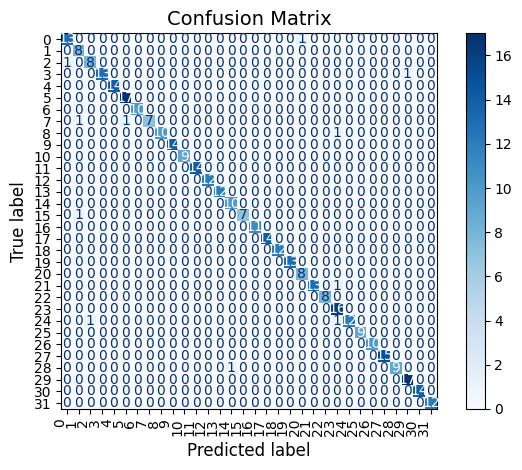

In [179]:
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
# Plot with adjusted size, label rotation, and font size
plt.figure(figsize=(5,15))  # Adjust the figure size
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Rotate labels
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Optionally, adjust font size
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Summary and Analysis


For this dataset of plant images, I extracted and tensorized the images and their labels (extracted from the csv file in folder). The data was preprocessed by resizing, converting to greyscale images, and normalizing the data. The data was then shuffled and split to pass into the model. From there the model trained and predicted on the test dataset and validation dataset. 

The model performed really well with validation metrics (precision, recall, f1 score) above 97%. Additional layers or parameters could be tested to see how that impacts the model results and if it can be improved. Room for improvement from a coding perspective, that i was attempting, was to calculate the recall / precision after each epoch, or built into the model itself. Additional analysis for this model is to calculate which images were misclassified the most to see if it's an issue with how those images were taken. 